In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import datetime as dt

Note: A large portion of this code was inspired by https://github.com/gonghui945

# Avalanche
AVAX-USD pair

In [2]:
coin = 'AVAX'
today = dt.datetime.strptime('2022-04-03', '%Y-%m-%d')
today

datetime.datetime(2022, 4, 3, 0, 0)

In [3]:
start = today - dt.timedelta(days=365)
historic_data = yf.download(f'{coin}-USD', start=start, end=today)
historic_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-02,28.332315,29.574100,28.043386,29.117611,29.117611,167497181
2021-04-03,29.081627,32.780338,28.199560,28.251848,28.251848,424655897
2021-04-04,28.299345,30.093628,27.917349,29.329712,29.329712,185849450
2021-04-05,29.310335,32.983772,28.740986,31.246593,31.246593,447418402
2021-04-06,31.278708,34.554840,30.200602,31.554495,31.554495,453065493
...,...,...,...,...,...,...
2022-03-29,89.523987,95.876266,89.514572,92.840889,92.840889,1642341694
2022-03-30,92.813957,100.078888,90.002953,95.779984,95.779984,1755845999
2022-03-31,95.692749,101.685379,94.261108,96.924660,96.924660,2201715680


In [4]:
adj_close = historic_data['Adj Close']

In [5]:
YTD_change = 100 * adj_close[-1]/adj_close[0]
print(f'YTD change of {coin}: {"%.2f" % YTD_change}%')

YTD change of AVAX: 329.61%


Text(0.5, 1.0, 'AVAX Spot Price')

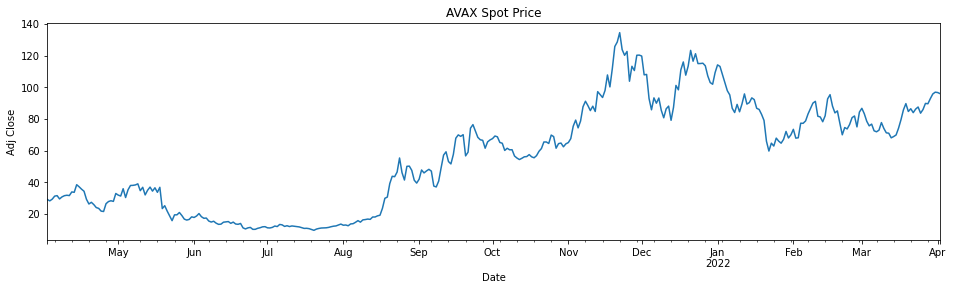

In [6]:
adj_close.plot(figsize=(16, 4))
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title(f'{coin} Spot Price')

In [7]:
def log_return(price_series):
    return np.log(price_series / price_series.shift()).dropna()

In [8]:
log_returns = log_return(historic_data['Adj Close'])

Text(0.5, 1.0, 'AVAX Log Return')

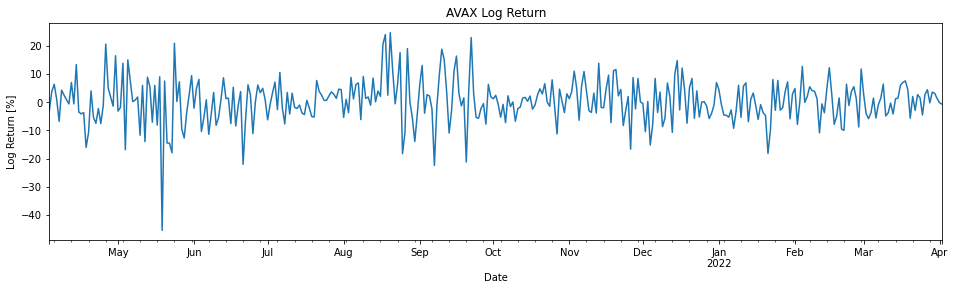

In [9]:
(log_returns*100).plot(figsize=(16, 4))
plt.xlabel('Date')
plt.ylabel('Log Return [%]')
plt.title(f'{coin} Log Return')

In [10]:
def volatility(price_series):
    return np.sqrt(365) * log_return(price_series).std() 

In [11]:
vol90 = volatility(historic_data['Adj Close'][-90:])
print(f'Volatility of the last 90 days: {"%.2f" % (vol90 * 100)} %')

Volatility of the last 90 days: 108.09 %


In [12]:
vol_before = volatility(historic_data['Adj Close'][:-90])
print(f'Volatility in the last year without the last 90 days: {"%.2f" % (vol_before * 100)} %')

Volatility in the last year without the last 90 days: 160.01 %


In [13]:
sigma = vol90

In [14]:
pad = 10
print('Log Returns (daily)')
print('='*19)
print('Avg:', ('%.4f' % np.average(log_returns*100)).rjust(pad), '%')
print('Min:', ('%.4f' % np.min(log_returns*100)).rjust(pad), '%')
print('Max:', ('%.4f' % np.max(log_returns*100)).rjust(pad), '%')
print('Std:', ('%.4f' % np.std(log_returns*100)).rjust(pad), '%')
print('\nAnnualized Volatility')
print('='*21)
print('Sigma:', '%.2f' % (sigma*100), '%')

Log Returns (daily)
Avg:     0.3268 %
Min:   -45.4052 %
Max:    24.6182 %
Std:     7.7788 %

Annualized Volatility
Sigma: 108.09 %


Text(0.5, 1.0, 'Frequency distribution of the AVAX Log Returns')

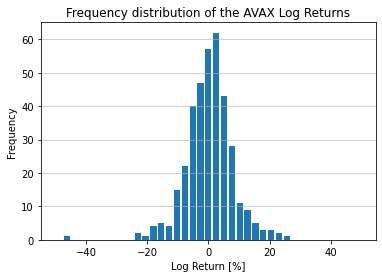

In [15]:
lr_bins = np.linspace(-50, 50, 40)
n, bins, patches = plt.hist(log_returns*100,bins=lr_bins, density=False, alpha=1, rwidth=0.8)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Log Return [%]')
plt.ylabel('Frequency')
plt.title(f'Frequency distribution of the {coin} Log Returns')

# Risk-Free Rate
Using 13-week T-bill (^IRX) as the risk-free rate.  
Among the commonly used risk-free rates in the industry, the rate for the 13-week T-bill is the rate with its majurity the closest to the time to expiry of this option. 

In [16]:
Tbill1M = yf.Ticker('^IRX')
Tbill1M_history = Tbill1M.history(start=historic_data.index[-1])
Tbill1M_history.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-01,0.498,0.505,0.498,0.5,0,0,0


In [17]:
rfr = Tbill1M_history['Close'][-1] * 0.01
print(f'Risk-free rate: {rfr*100}%')

Risk-free rate: 0.5%


# Pricing for European Options

## Option Parameters

In [18]:
K = 110         # strike
T = 14/365      # 2 weeks
payoff = "call" # "call" or "put"

## Derived Parameters

Current Asset Price (S):

In [19]:
S = adj_close[-1]
print(f'Current Price of AVAX: USD { "%.2f" %S}')

Current Price of AVAX: USD 95.97


## Binomial Tree
Pricing using the Binomial Tree Model

In [20]:
def euro_option_bt(S0, K, T, r, sigma, payoff, N = 10):
    dT = float(T) / N             # time delta
    u = np.exp(sigma * np.sqrt(dT)) # up factor
    d = 1.0 / u                   # down factor
    
    a = np.exp(r * dT)            # risk free compound return
    p = (a - d)/ (u - d)          # risk neutral up probability
    q = 1.0 - p                   # risk neutral down probability
    
    # Fill Price Tree Left to Right
    S = np.zeros((N + 1, N + 1))
    S[0, 0] = S0
    z = 1
    for t in range(1, N + 1):
        for i in range(z):
            S[i, t] = S[i, t-1] * u
            S[i+1, t] = S[i, t-1] * d
        z += 1
        
    # Fill Value Tree Right to Left
    S_T = S[:,-1]
    V = np.zeros((N + 1, N + 1))
    if payoff =="call":
        V[:,-1] = np.maximum(S_T-K, 0)
    elif payoff =="put":
        V[:,-1] = np.maximum(K-S_T, 0)
        
    for j in range(N-1, -1, -1):
        for i in range(j+1):
            V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
            
    # Current value is in the first cell
    return V[0,0]

In [21]:
value_bt = euro_option_bt(S, K, T, rfr, sigma, payoff)

## Monte Carlo Simulation
For European-style options

In [22]:
def mcs_simulation_np(S0, sigma, T, r, M, I):
    
    #S0:    spot price
    #sigma: standard deviation
    #K:     strike price
    #T:     time to maturity
    #r:     risk free rate
    #M:     # of steps
    #I:     # of simulations
    
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [23]:
def euro_option_mcs(S, K, T, r, sigma, payoff, M = 1_000, I = 10_000):
    
    #S:     spot price
    #sigma: standard deviation
    #K:     strike price
    #T:     time to maturity
    #r:     risk free rate
    #M:     # of steps
    #I:     # of simulations
    
    simulation = mcs_simulation_np(S, sigma, T, r, M, I)
    last_prices = simulation[-1]
    if payoff == "call":
        return np.mean(np.maximum(last_prices - K,0))
    if payoff == "put":
        return np.mean(np.maximum(K - last_prices,0))

In [24]:
adj_close.tail()

Date
2022-03-29    92.840889
2022-03-30    95.779984
2022-03-31    96.924660
2022-04-01    96.693184
2022-04-02    95.973267
Name: Adj Close, dtype: float64

In [25]:
mcs_prices = [euro_option_mcs(S, K, T, rfr, sigma, payoff) for _ in range(100)]

In [26]:
value_mcs = np.mean(mcs_prices)

## Black-Scholes Model
European-style option pricing

In [27]:
def euro_option_bsm(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [28]:
value_bsm = euro_option_bsm(S, K, T, rfr, sigma, payoff)

## Variable ranges
Define interesting ranges

In [29]:
midS = (S + K) / 2
dS = (1 + sigma) * midS / 10
s_space = np.linspace(midS - dS,midS + dS,101)
t_space = np.linspace(1/365,T,101)
r_space = np.linspace(0,0.02,101)
sigma_space = np.linspace(0.7*sigma,1.3*sigma,101)

## Plot style

In [30]:
def plot2d(x, y, x_label, y_label, title):
    fig = plt.figure(figsize=(16, 4))
    plt.plot(x, y, '-')
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    return plt.title(title)

In [31]:
def plot3d(x, y, z, x_label, y_label, z_label, title):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    x_mesh, y_mesh = np.meshgrid(x, y)
    surf = ax.plot_surface(x_mesh, y_mesh, z, rstride=1, cstride=1, cmap=plt.cm.seismic, linewidth=1, alpha=0.9, antialiased=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label.ljust(5)) # Ensure label is vertical to avoid overlap with colorbar
    ax.set_title(title)
    return fig.colorbar(surf, shrink=0.5, aspect=5)

## Value

In [32]:
price_values = [euro_option_bsm(s, K, T, rfr, sigma, payoff) for s in s_space]
payoff_values = [ max(s-K, 0) for s in s_space]

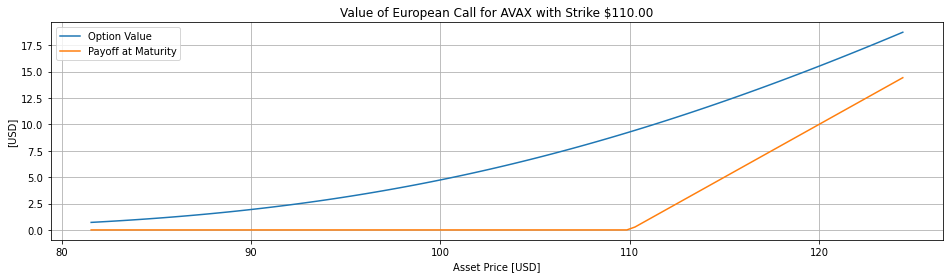

In [33]:
plot2d(s_space, price_values,
       'Asset Price [USD]', '[USD]',
       f'Value of European {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')
plt.plot(s_space, payoff_values)
plt.legend(['Option Value', 'Payoff at Maturity'])

## Summary

In [73]:
pad = 20
print('Coin:'.ljust(pad), coin)
print('Current Price:'.ljust(pad), '%.2f' % S, 'USD')
print('Volatility:'.ljust(pad), '%.2f' % (sigma*100), '%')
print('Risk-free Rate:'.ljust(pad), '%.2f' % (rfr*100), '%')
print('\nOption')
print('='*pad)
print('Payoff:'.ljust(pad), payoff.capitalize())
print('Strike:'.ljust(pad), '%.2f' % K, 'USD')
print('Time to Maturity:'.ljust(pad), '%.2f' % (T*365), 'days')
print('Value Binomial Tree:'.ljust(pad), '%.2f' % value_bt, 'USD')
print('Value Monte Carlo:'.ljust(pad), '%.2f' % value_mcs, 'USD')
print('Value Black-Scholes:'.ljust(pad), '%.2f' % value_bsm, 'USD')

Coin:                AVAX
Current Price:       95.97 USD
Volatility:          108.09 %
Risk-free Rate:      0.50 %

Option
Payoff:              Call
Strike:              110.00 USD
Time to Maturity:    14.00 days
Value Binomial Tree: 3.23 USD
Value Monte Carlo:   3.41 USD
Value Black-Scholes: 3.41 USD


## Greeks

### Delta

In [35]:
def delta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta = - si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [36]:
current_delta = delta(S, K, T, rfr, sigma, payoff)
print(f'The value of Delta is {"%.4f" % current_delta}. If the underlying asset price increases by USD 1, the value of the option will increase by USD {"%.4f" % (current_delta)}.')

The value of Delta is 0.2954. If the underlying asset price increases by USD 1, the value of the option will increase by USD 0.2954.


In [37]:
delta_values = [delta(s, K, T, rfr, sigma, payoff) for s in s_space ]

Text(0.5, 1.0, 'Delta of Call for AVAX with Strike $110.00')

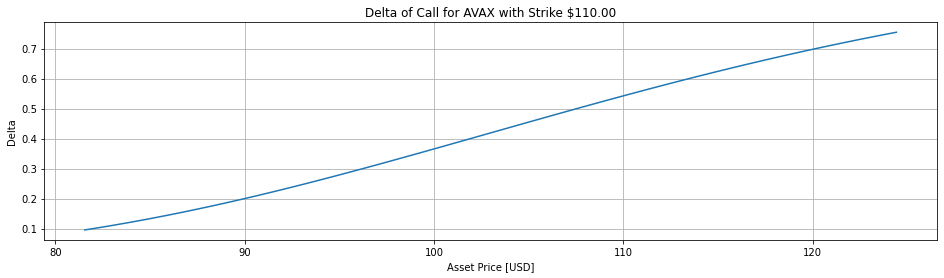

In [38]:
plot2d(s_space, delta_values,
       'Asset Price [USD]', 'Delta',
       f'Delta of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

#### 3D Plot

In [39]:
delta_values_3d = np.asmatrix([[delta(s, K, t, rfr, sigma, 'call') for s in s_space]  for t in t_space])

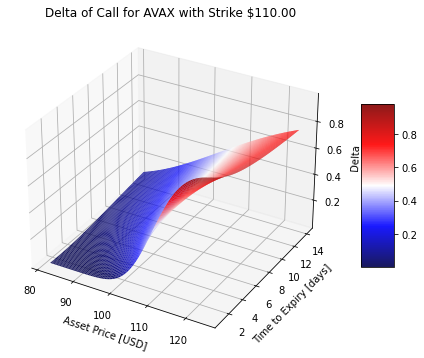

In [40]:
plot3d(s_space, t_space * 365, delta_values_3d,
       'Asset Price [USD]', 'Time to Expiry [days]', 'Delta',
       f'Delta of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

### Gamma

In [41]:
def gamma(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [42]:
current_gamma = gamma(S, K, T, rfr, sigma, payoff)
print(f'The value of Gamma is {"%.4f" % current_gamma}. If the underlying asset price increases by USD 1, the value of Delta will increase by {"%.4f" % (current_gamma)}.')

The value of Gamma is 0.0170. If the underlying asset price increases by USD 1, the value of Delta will increase by 0.0170.


In [43]:
gamma_values = [gamma(s, K, T, rfr, sigma, payoff) for s in s_space ]

Text(0.5, 1.0, 'Gamma of Call for AVAX with Strike $110.00')

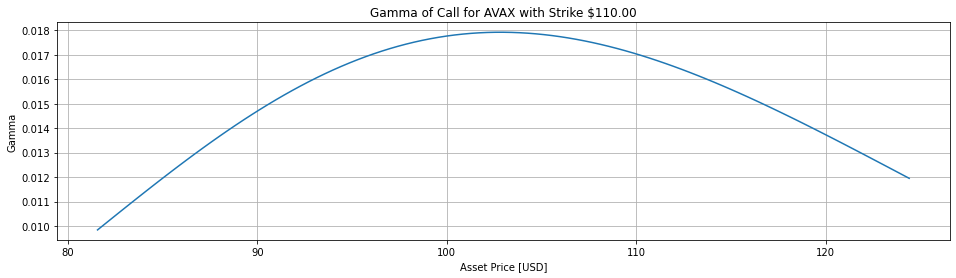

In [44]:
plot2d(s_space, gamma_values,
       'Asset Price [USD]', 'Gamma',
       f'Gamma of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

#### 3D Plot

In [45]:
gamma_values_3d = np.asmatrix([[gamma(s, K, t, rfr, sigma, 'call') for s in s_space]  for t in t_space])

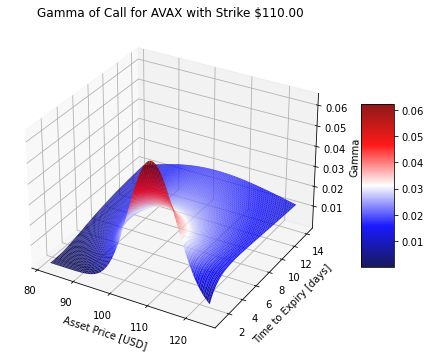

In [46]:
plot3d(s_space, t_space * 365, gamma_values_3d,
       'Asset Price [USD]', 'Time to Expiry [days]', 'Gamma',
       f'Gamma of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

### Speed

In [47]:
def speed(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [48]:
current_speed = speed(S, K, T, rfr, sigma, payoff)
print(f'The value of Speed is {"%.4f" % current_speed}. If the underlying asset price increases by USD 1, the value of Gamma will increase by {"%.4f" % (current_speed)}.')

The value of Speed is 0.0001. If the underlying asset price increases by USD 1, the value of Gamma will increase by 0.0001.


In [49]:
speed_values = [speed(s, K, T, rfr, sigma, payoff) for s in s_space]

Text(0.5, 1.0, 'Speed of Call for AVAX with Strike $110.00')

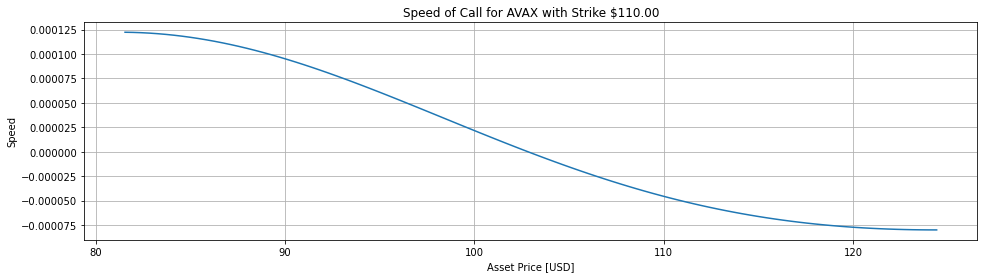

In [50]:
plot2d(s_space, speed_values,
       'Asset Price [USD]', 'Speed',
       f'Speed of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

In [51]:
speed_values_3d = np.asmatrix([[speed(s, K, t, rfr, sigma, 'call') for s in s_space]  for t in t_space])

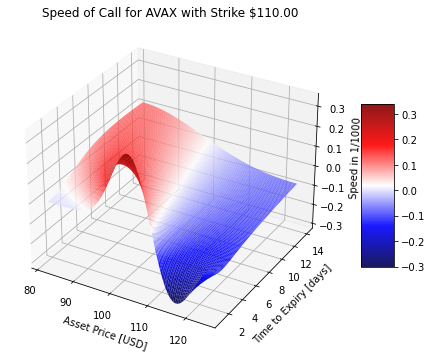

In [52]:
plot3d(s_space, t_space * 365, speed_values_3d * 1000,
       'Asset Price [USD]', 'Time to Expiry [days]', 'Speed in 1/1000',
       f'Speed of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}'
      )

### Theta

In [53]:
def theta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta


In [54]:
current_theta = theta(S, K, T, rfr, sigma, payoff)
print(f'The value of Theta is {"%.4f" % current_theta}. If the time to expiry decreases by 1 day , the value of the option will increase by USD {"%.4f" % (current_theta*1/365)}.')

The value of Theta is 91.5596. If the time to expiry decreases by 1 day , the value of the option will increase by USD 0.2508.


In [55]:
theta_values = np.array([theta(S, K, t, rfr, sigma, 'call') for t in t_space ])

Text(0.5, 1.0, 'Theta of Call for AVAX with Strike $110.00')

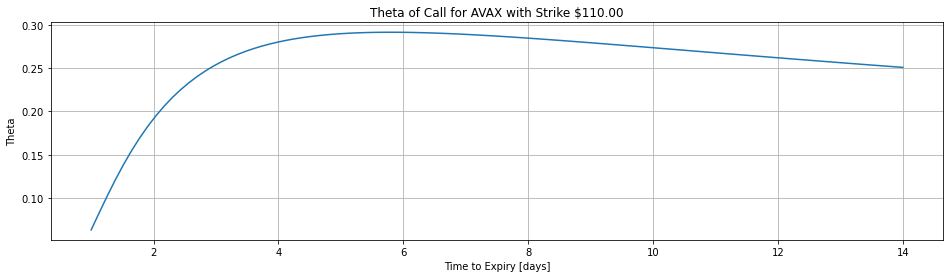

In [56]:
plot2d(t_space * 365, theta_values / 365,
       'Time to Expiry [days]', 'Theta',
       f'Theta of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

In [57]:
theta_values_3d_s = np.asmatrix([[theta(s, K, t, rfr, sigma, payoff) for s in s_space]  for t in t_space])

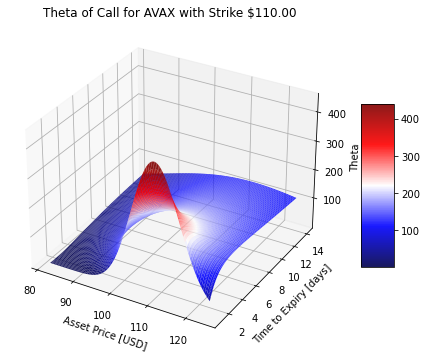

In [58]:
plot3d(s_space, t_space * 365, theta_values_3d_s,
       'Asset Price [USD]', 'Time to Expiry [days]', 'Theta',
       f'Theta of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}'
      )

In [59]:
theta_values_3d_v = np.asmatrix([[theta(S, K, t, rfr, sigma, payoff) for sigma in sigma_space]  for t in t_space])

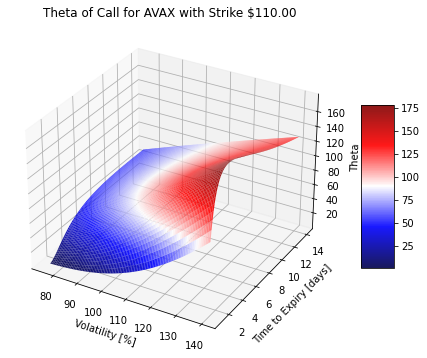

In [60]:
plot3d(sigma_space*100, t_space * 365, theta_values_3d_v,
       'Volatility [%]', 'Time to Expiry [days]', 'Theta',
       f'Theta of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}'
      )

### Rho

In [61]:
def rho(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [62]:
current_rho = rho(S, K, T, rfr, sigma, payoff)
print(f'The value of Rho is {"%.4f" % current_rho}. If the risk-free rate increases by one percentage point, the value of the option will increase by USD {"%.4f" % (current_rho*0.01)}.')

The value of Rho is 0.9568. If the risk-free rate increases by one percentage point, the value of the option will increase by USD 0.0096.


In [63]:
rho_values = [rho(S, K, T, r, sigma, payoff) for r in r_space ]

Text(0.5, 1.0, 'Rho of Call for AVAX with Strike $110.00')

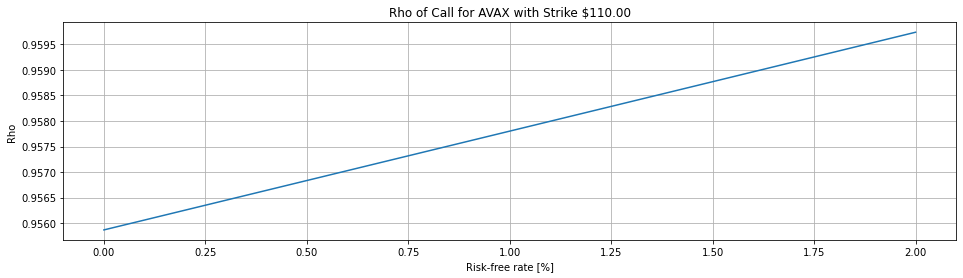

In [64]:
plot2d(r_space * 100, rho_values,
       'Risk-free rate [%]', 'Rho',
       f'Rho of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

In [65]:
rho_values_3d = np.asmatrix([[rho(S, K, t, r, sigma, payoff) for r in r_space]  for t in t_space])

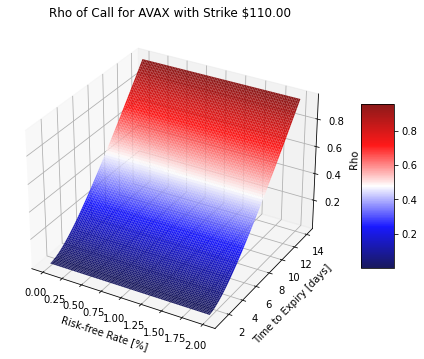

In [66]:
plot3d(r_space * 100, t_space * 365, rho_values_3d,
       'Risk-free Rate [%]', 'Time to Expiry [days]', 'Rho',
       f'Rho of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}'
      )

### Vega

In [67]:
def vega(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [68]:
current_vega = vega(S, K, T, rfr, sigma, payoff)
print(f'The value of Vega is {"%.4f" % current_vega}. If the volatility increases by one percentage point, the value of the option will increase by USD {"%.4f" % (current_vega*0.01)}.')

The value of Vega is 6.4894. If the volatility increases by one percentage point, the value of the option will increase by USD 0.0649.


In [69]:
vega_values = [vega(S, K, T, rfr, sigma, payoff) for sigma in sigma_space ]

Text(0.5, 1.0, 'Vega of Call for AVAX with Strike $110.00')

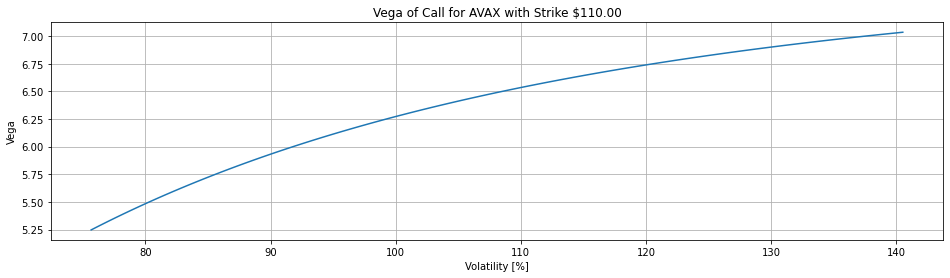

In [70]:
plot2d(sigma_space * 100, vega_values,
       'Volatility [%]', 'Vega',
       f'Vega of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')

In [71]:
vega_values_3d = np.asmatrix([[vega(s, K, t, rfr, sigma, payoff) for s in s_space]  for t in t_space])

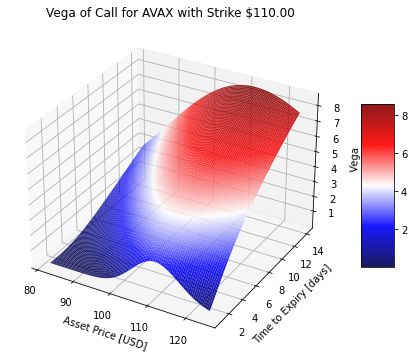

In [72]:
plot3d(s_space, t_space * 365, vega_values_3d,
       'Asset Price [USD]', 'Time to Expiry [days]', 'Vega',
       f'Vega of {payoff.capitalize()} for {coin} with Strike ${"%.2f" % K}')